In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
data_dir = 'dataset/'
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Load and combine all data
df_list = [pd.read_csv(os.path.join(data_dir, file)) for file in csv_files]
df_combined = pd.concat(df_list, ignore_index=True)

# Check the combined dataframe
print(df_combined.shape)
print(df_combined.head())

(2830743, 79)
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6   

## Data Pre Process

In [3]:
# Remove leading/trailing spaces from column names
df_combined.columns = df_combined.columns.str.strip()

In [4]:
# Handle missing values
df_combined = df_combined.dropna()

In [5]:
print(df_combined.columns)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [6]:
# Basic statistics
print(df_combined.describe())

       Destination Port  Flow Duration  Total Fwd Packets  \
count      2.829385e+06   2.829385e+06       2.829385e+06   
mean       8.071249e+03   1.479276e+07       9.364763e+00   
std        1.828343e+04   3.366026e+07       7.498527e+02   
min        0.000000e+00  -1.300000e+01       1.000000e+00   
25%        5.300000e+01   1.550000e+02       2.000000e+00   
50%        8.000000e+01   3.132700e+04       2.000000e+00   
75%        4.430000e+02   3.221416e+06       5.000000e+00   
max        6.553500e+04   1.200000e+08       2.197590e+05   

       Total Backward Packets  Total Length of Fwd Packets  \
count            2.829385e+06                 2.829385e+06   
mean             1.039869e+01                 5.495661e+02   
std              9.976276e+02                 9.995980e+03   
min              0.000000e+00                 0.000000e+00   
25%              1.000000e+00                 1.200000e+01   
50%              2.000000e+00                 6.200000e+01   
75%             

In [7]:
# Check label distribution
print(df_combined['Label'].value_counts())

Label
BENIGN                        2272688
DoS Hulk                       230124
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [8]:
import numpy as np
import pandas as pd

# Select only numeric columns
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns

In [9]:
# Find columns with infinite values (numeric only)
inf_cols = df_combined[numeric_cols].columns[np.isinf(df_combined[numeric_cols]).any()]
print("Columns with infinite values:", inf_cols)

Columns with infinite values: Index(['Flow Bytes/s', 'Flow Packets/s'], dtype='object')


In [10]:
# Make a copy to preserve original data
df_clean = df_combined.copy()

# Handle infinite values in numeric columns only
for col in numeric_cols:
    if col in inf_cols:
        # Replace inf with max finite value or NaN
        max_finite = df_clean[col][np.isfinite(df_clean[col])].max()
        df_clean[col] = df_clean[col].replace([np.inf, -np.inf], max_finite)

In [11]:
# Check if any infinite values remain
print("Remaining infinite values:", np.isinf(df_clean[numeric_cols]).any().any())

Remaining infinite values: False


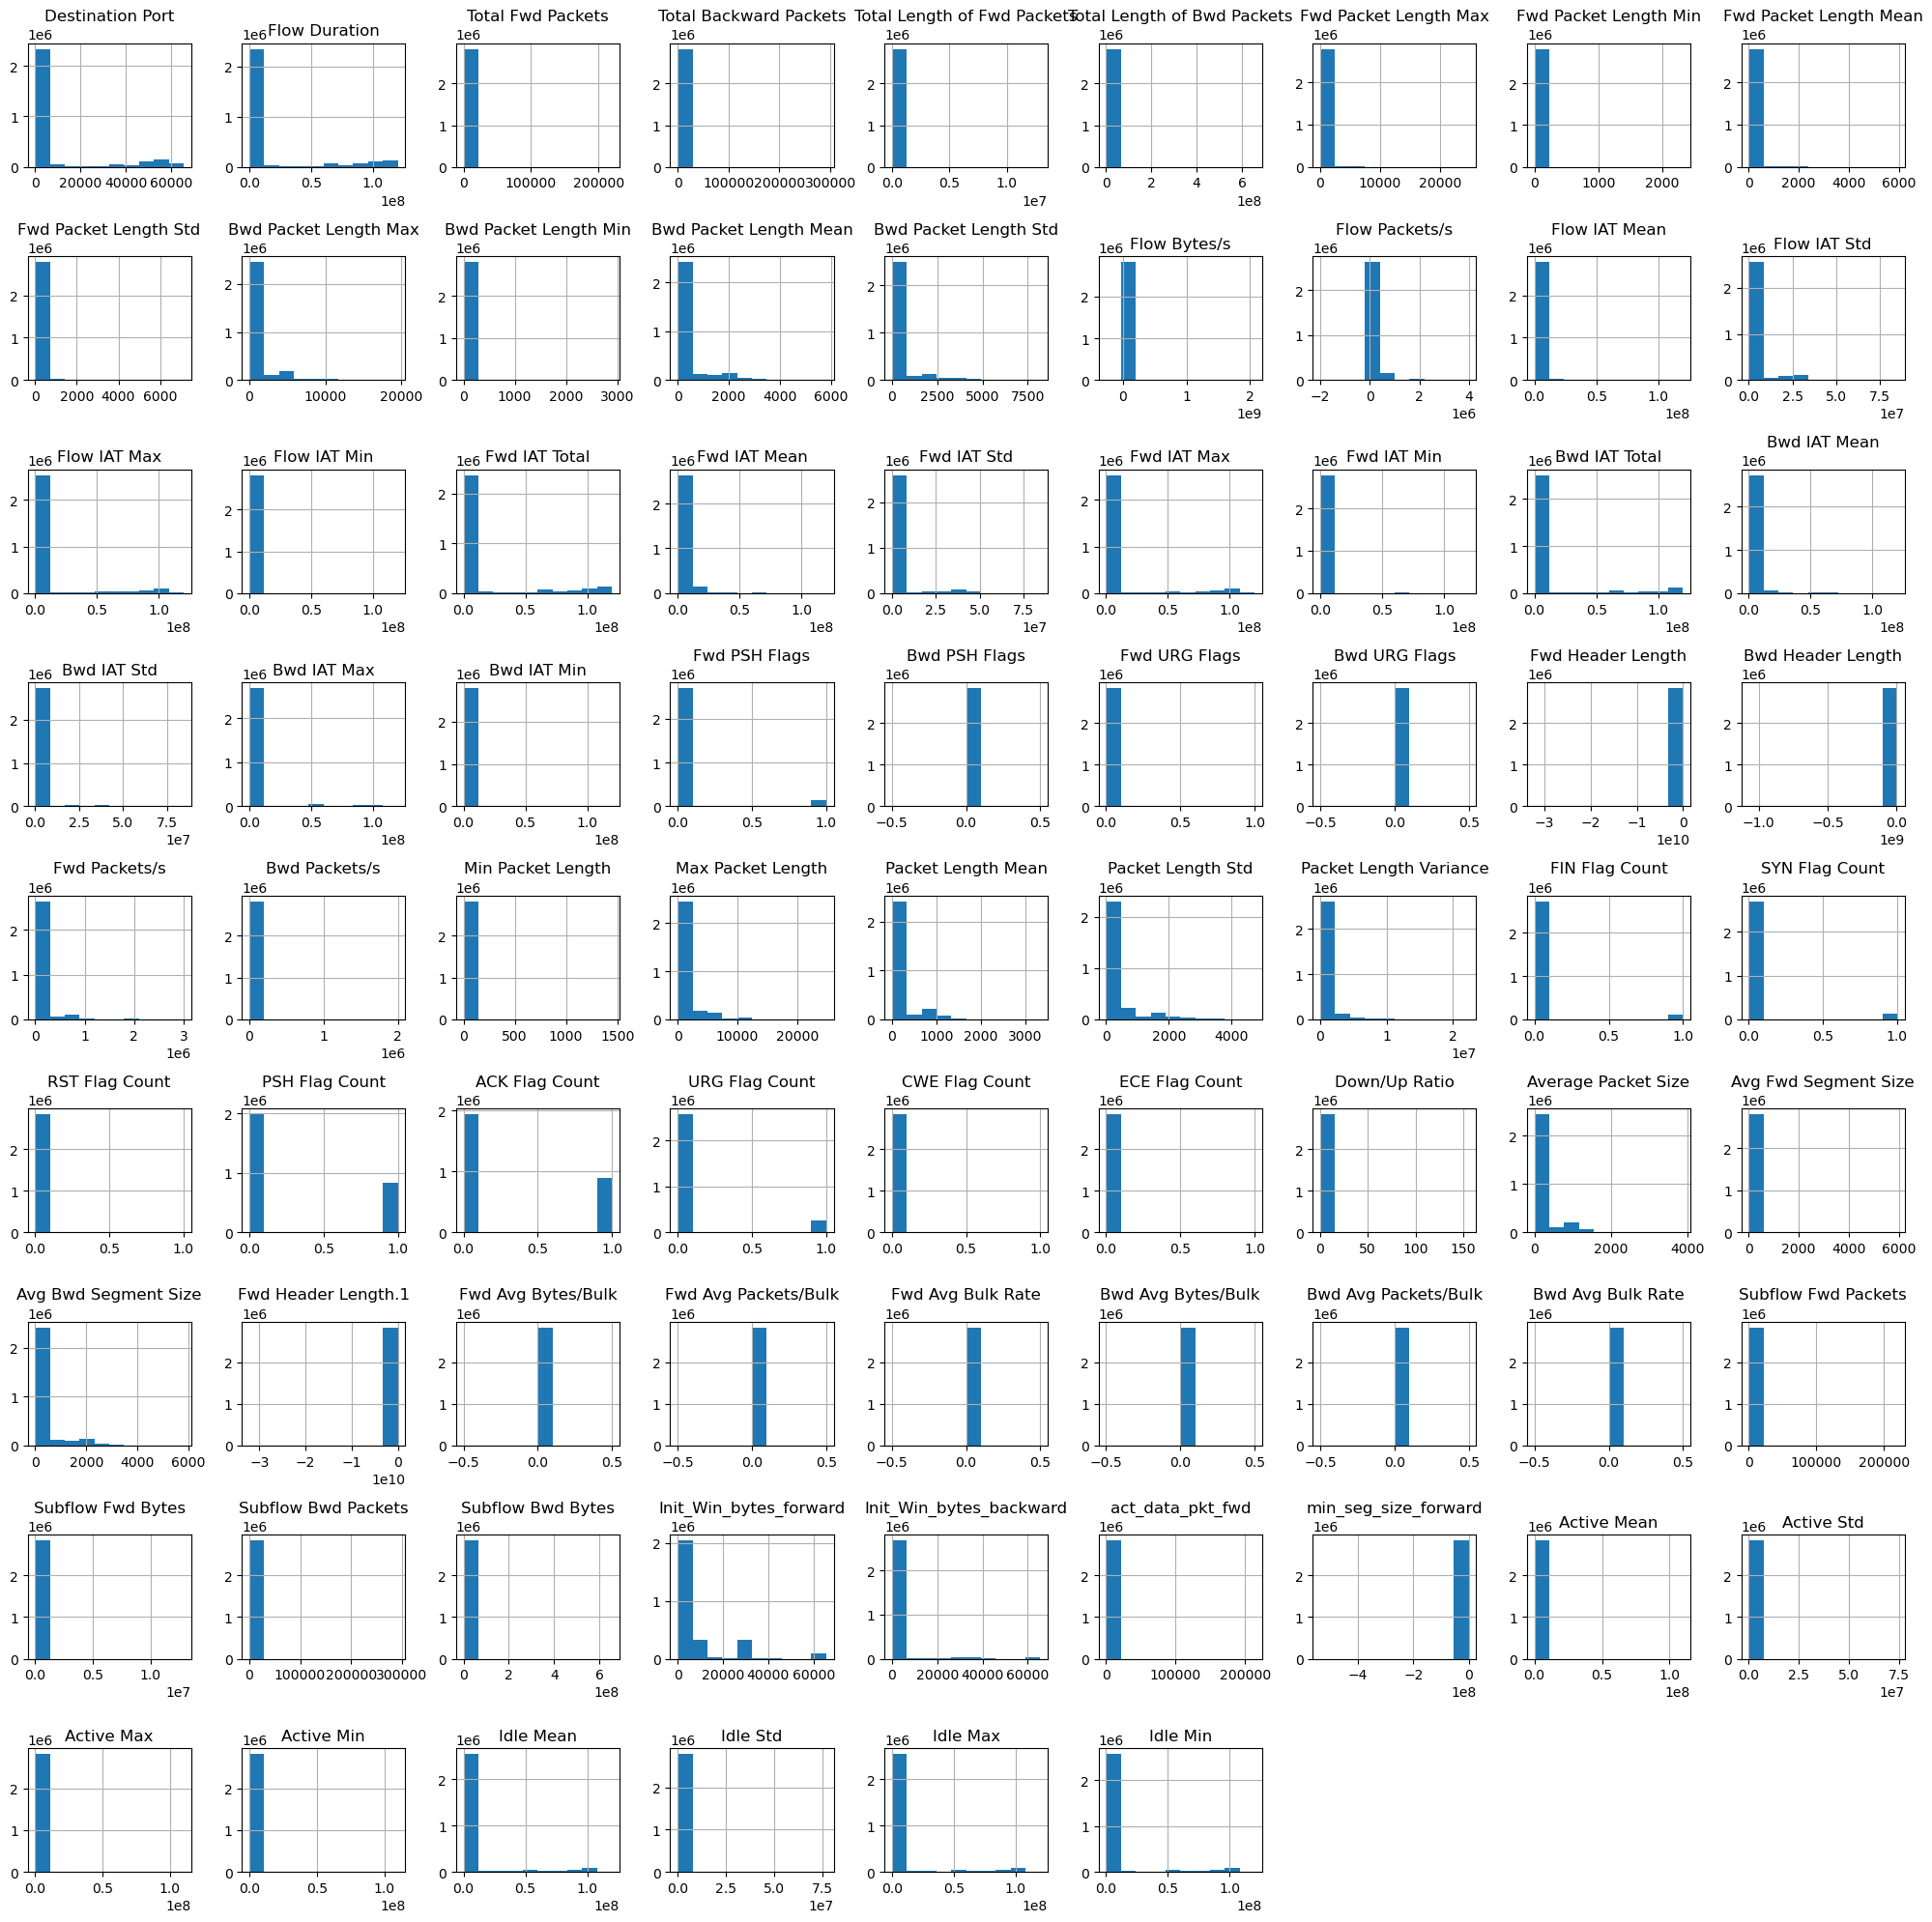

In [12]:
# Visualize feature distributions
import matplotlib.pyplot as plt
df_clean.hist(figsize=(20, 20))
plt.tight_layout()
plt.show()

#### Encode Labels

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

df_clean['Label'] = encoder.fit_transform(df_clean['Label'])

### Feature Normalizing

In [14]:
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = df_clean.drop('Label', axis=1)
y = df_clean['Label']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 20 features
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_scaled, y)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [31 33 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Reshape the data for CNN
# We'll reshape X_selected to (samples, features, 1)
X_selected_reshaped = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_reshaped, y, test_size=0.2, random_state=42)

### CNN Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [19]:
# Initialize the model
model = Sequential()

# Add the 1D convolutional layer
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another convolutional layer
model.add(Conv1D(128, 3, activation='relu'))

# Add another max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout to prevent overfitting
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output layer with one unit per class

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 18, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,575 (197.56 KB)

 Trainable params: 50,575 (197.56 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
70735/70735 ━━━━━━━━━━━━━━━━━━━━ 202s 3ms/step - accuracy: 0.9255 - loss: 0.2259 - val_accuracy: 0.9478 - val_loss: 0.1370
Epoch 2/10
70735/70735 ━━━━━━━━━━━━━━━━━━━━ 197s 3ms/step - accuracy: 0.9467 - loss: 0.1459 - val_accuracy: 0.9629 - val_loss: 0.1272
Epoch 3/10
70735/70735 ━━━━━━━━━━━━━━━━━━━━ 192s 3ms/step - accuracy: 0.9484 - loss: 0.1385 - val_accuracy: 0.9623 - val_loss: 0.1278
Epoch 4/10
70735/70735 ━━━━━━━━━━━━━━━━━━━━ 190s 3ms/step - accuracy: 0.9501 - loss: 0.1358 - val_accuracy: 0.9520 - val_loss: 0.1208
Epoch 5/10
70735/70735 ━━━━━━━━━━━━━━━━━━━━ 189s 3ms/step - accuracy: 0.9515 - loss: 0.1341 - val_accuracy: 0.9499 - val_loss: 0.1239
Epoch 6/10
70735/70735 ━━━━━━━━━━━━━━━━━━━━ 190s 3ms/step - accuracy: 0.9533 - loss: 0.1338 - val_accuracy: 0.9520 - val_loss: 0.1279
Epoch 7/10
70735/70735 ━━━━━━━━━━━━━━━━━━━━ 189s 3ms/step - accuracy: 0.9538 - loss: 0.1339 - val_accuracy: 0.9611 - val_loss: 0.1247
Epoch 8/10
70735/70735 ━━━━━━━━━━━━━━━━━━━━ 190s 3ms/step - ac

In [21]:
# Save the trained model
model.save('cnn_model.h5')

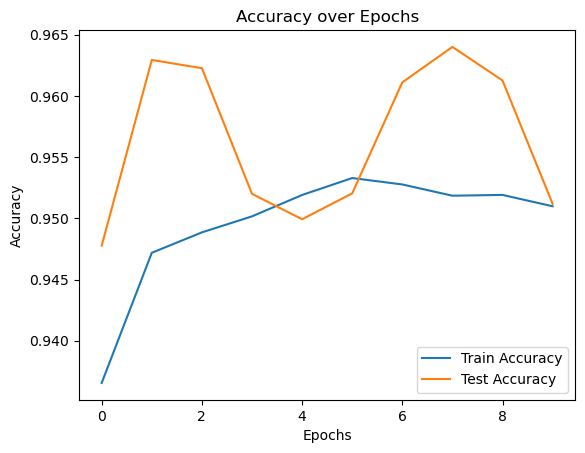

In [22]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

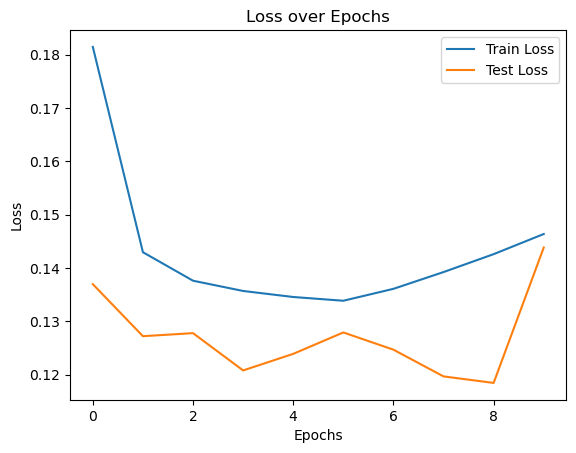

In [23]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

17684/17684 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


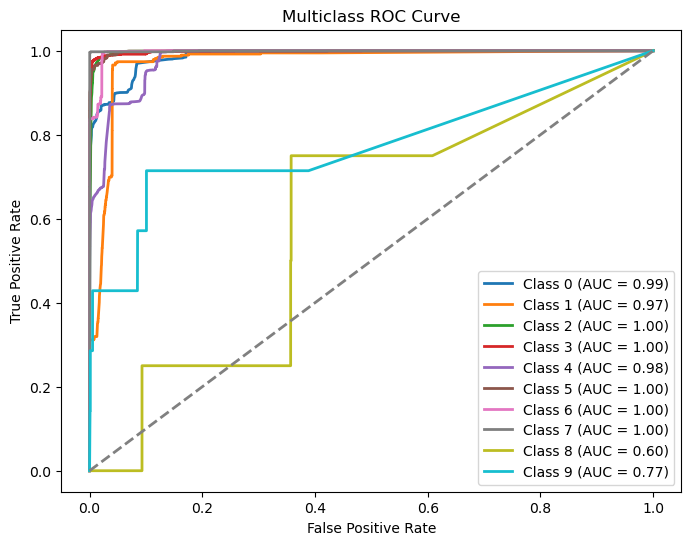

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Assuming you have more than 2 classes, so we need to binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) 

# Predict probabilities for each class
y_pred_prob = model.predict(X_test)

# Initialize the plot
plt.figure(figsize=(8, 6))

# Calculate ROC curve and AUC for each class
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for each class
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing (diagonal line)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()


17684/17684 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


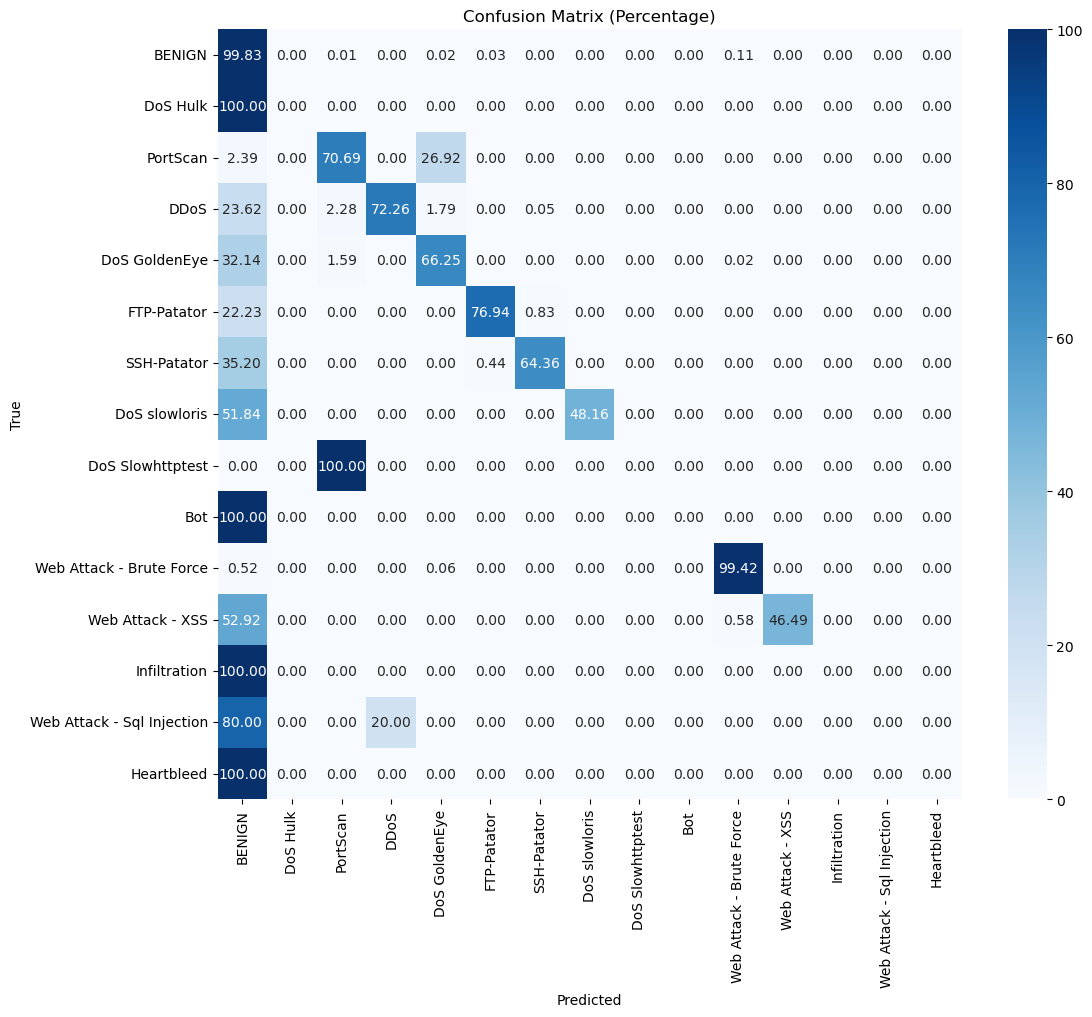

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the predicted class labels (using argmax if you have probabilities)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)

# List of your class labels
class_labels = [
    "BENIGN", "DoS Hulk", "PortScan", "DDoS", "DoS GoldenEye", 
    "FTP-Patator", "SSH-Patator", "DoS slowloris", "DoS Slowhttptest", 
    "Bot", "Web Attack - Brute Force", "Web Attack - XSS", "Infiltration", 
    "Web Attack - Sql Injection", "Heartbleed"
]

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix by row (i.e., by the total number of samples in each class)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix as a heatmap with percentages
plt.figure(figsize=(12,10))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()